# Image Tsne

### Import Variables

In [23]:
%matplotlib inline
import random
import numpy as np
import pickle
from PIL import Image
from scipy.spatial import distance
import igraph
import cv2
import os
from skimage import io
from sklearn.feature_extraction import image
from sklearn.manifold import TSNE
from tqdm import tqdm

### Parse all images in custom folder, saves their color and path into the data array

See: `Save images from Wikidata.ipynb` to create a folder containing images from Wikidata.

In [24]:
data = []
folder = '../assets/wikidata_crop/'

for filename in tqdm((os.listdir(folder))):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        image = image.flatten()
        data.append([image, folder + filename])


100%|████████████████████████████████████████| 483/483 [00:00<00:00, 630.50it/s]


In [25]:
features, images  = zip(*data)

### Training part

imagesinstantiate a PCA object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

In [26]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [27]:
num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [28]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=350, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

/Users/giacomonanni/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 483 samples in 0.002s...
[t-SNE] Computed neighbors for 483 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 483 / 483
[t-SNE] Mean sigma: 661.771178
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 82.9153214, gradient norm = 0.3001590 (50 iterations in 0.147s)
[t-SNE] Iteration 100: error = 81.9980316, gradient norm = 0.3378250 (50 iterations in 0.103s)
[t-SNE] Iteration 150: error = 85.8404236, gradient norm = 0.3120719 (50 iterations in 0.098s)
[t-SNE] Iteration 200: error = 83.6257477, gradient norm = 0.3077196 (50 iterations in 0.102s)
[t-SNE] Iteration 250: error = 85.5373688, gradient norm = 0.3076629 (50 iterations in 0.098s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.537369
[t-SNE] Iteration 300: error = 1.1717238, gradient norm = 0.0068528 (50 iterations in 0.095s)
[t-SNE] Iteration 350: error = 0.9162972, gradient norm = 0.0021714

Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable tsne contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [29]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Plots the clusters

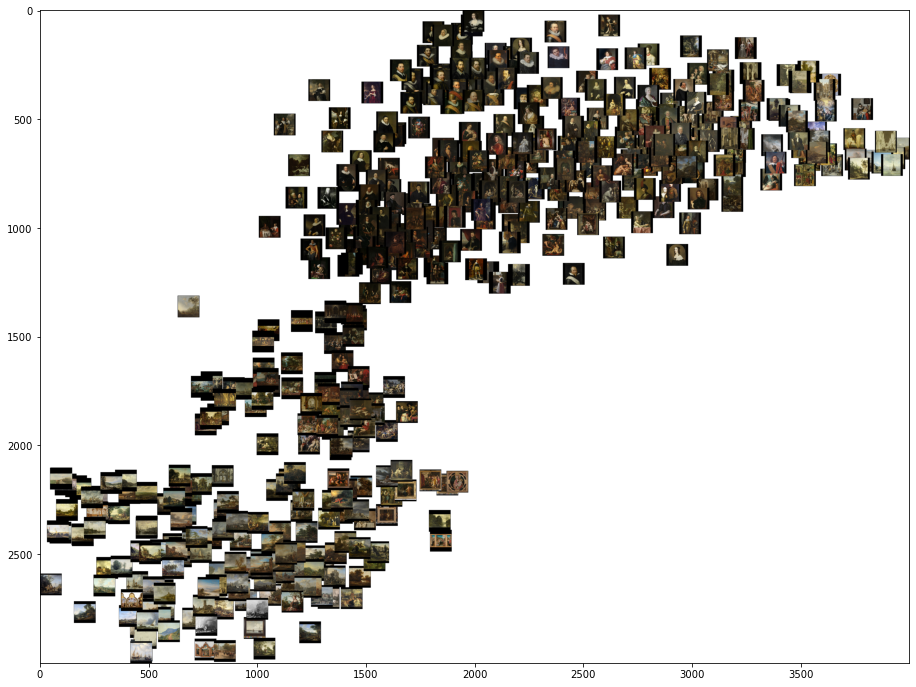

In [30]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

### Save a json and a png of the cluster

In [36]:
import os
import json

full_image.save("../data/test_tSNE.png")

tsne_path = "../data/test_tSNE.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)


saved t-SNE result to ../data/test_tSNE.json


### Paste into grid

In [31]:
import rasterfairy
nx = 20
ny = 20

grid_assignment = rasterfairy.transformPointCloud2D(tsne)

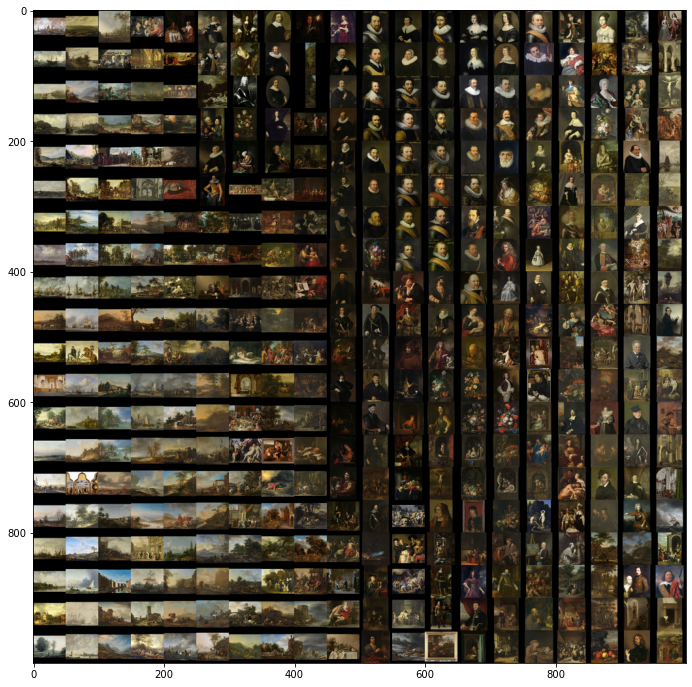

In [33]:
tile_width = 50
tile_height = 50

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [37]:
background = Image.new("RGB", grid_image.size, (255, 255, 255))
background.paste(grid_image, mask=grid_image.split()[3]) # 3 is the alpha channel

background.save('../data/grid-tSNE.jpg', 'JPEG', quality=100)